In [1]:
# import libraries
import sys
sys.path += ["../src"]
import utils
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import subplots as sbp 
from importlib import reload
import jl_vae
import pickle
from tqdm import tqdm
# import jl_nflows_geo_coordinates_2 as nfg
# from jl_nflows_geo_coordinates import load_nf as load_dict

from _51_abm_functions import cod_prov_abbrv_df

# Global Spatial Autocorrelation
from spatial_autocorrelation import get_moransI, moransI_scatterplot, hypothesis_testing
# Local Spatial Autocorrelation
from spatial_autocorrelation import get_localMoransI, LISA_scatterplot
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import pairwise_distances
import gower

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

def ConvertBool2number(df):
    """Function to convert boolean columns to numeric"""
    bool_cols = df.select_dtypes(include=bool).columns
    df[bool_cols] = df[bool_cols].astype(float)
    df = df.reset_index(drop=True)
    return df

def DataPreparation_Privacy(data,keys):
    """Function to prepare the data for the privacy analyses"""
    
    df_real = ConvertBool2number(data['df_real']) 
    df_real95 = ConvertBool2number(data['df_real95'])
    df_excluded = ConvertBool2number(df_real[~df_real.index.isin(df_real95.index)])
    df_real95['descr'] = 0 #'real95'
    df_excluded['descr'] = 1 #'real_excluded'

    # nf + VAE
    df_nfvae = ConvertBool2number(data['df_nfvae']) 
    df_nfvae95 = ConvertBool2number(data['df_nfvae95']) 
    df_nfvae['descr'] = 2 #'nfvae'
    df_nfvae95['descr'] = 3 #'nfvae95'
    # ablation (only VAE)
    df_vae = ConvertBool2number(data['df_ablation'])
    df_vae95 = ConvertBool2number(data['df_ablation95'])
    df_vae['descr'] = 4 #'vae'
    df_vae95['descr'] = 5 #'vae95'
    # ipf
    df_ipf = ConvertBool2number(data['df_ipf']) 
    df_ipf95 = ConvertBool2number(data['df_ipf95']) 
    df_ipf['descr'] = 6 #'ipf'
    df_ipf95['descr'] = 7 #'ipf95'
    # copula + nf (95%)
    df_copulanf = ConvertBool2number(data['df_copula_nf'])
    df_copulanf95 = ConvertBool2number(data['df_copula_nf95'])
    df_copulanf['descr'] = 8 #'copulanf'
    df_copulanf95['descr'] = 9 #'copulanf95'
    # copula (95%)
    df_copula = ConvertBool2number(data['df_copula_ablation'])
    df_copula95 = ConvertBool2number(data['df_copula_ablation95'])
    df_copula['descr'] = 10 #'copula'
    df_copula95['descr'] = 11 #'copula95'

    df = pd.concat([df_real95,df_excluded,
                df_nfvae,df_nfvae95,
                df_vae,df_vae95,
                df_ipf,df_ipf95,
                df_copulanf,df_copulanf95,
                df_copula,df_copula95])
    
    df = (df-df.min())/(df.max()-df.min()) # all populations (for the same province) are scaled within the same metric space
    df = df.fillna(0)

    unique_descr = df.descr.unique()
    data_out = dict()
    for i in range(len(keys)):
        a = df.loc[df.descr == unique_descr[i],:].drop(columns='descr').reset_index(drop=True)
        data_out[keys[i]] = a

    return data_out


def Distance_x1(x1,metric='euclidean'):
    """Function to compute the distance between all point in a set, exception made for the point at hand"""
    # Distance matrix
    if(metric=='euclidean'):
        dists = pairwise_distances(x1.values, metric='euclidean') 
    elif(metric=='norm1'):
        dists = pairwise_distances(x1.values, metric='minkowski', p=1)
    elif(metric == 'gower'):
        dists = gower.gower_matrix(x1)

    np.fill_diagonal(dists, np.inf) 
    #del df2
    # take the minimum distances
    min_dists = dists.min(axis=1)

    return min_dists

def TableDistance(data, control_data, test_data = 'df_real95',metric='euclidean'):
    """Function that computes the distance between the real records to the synthetic ones, returning some statistics"""
    
    #df1 = data[test_data] # dataframe containing the data considered in computing the distances
    res = pd.DataFrame(columns=['mean','std','cv','min','5%','25%','50%','75%','95%','max'])
    for i in control_data:
        # Distance matrix
        if(metric=='euclidean'):
            dists = pairwise_distances(data[test_data].values,data[i].values, metric='euclidean') 
        elif(metric=='norm1'):
            dists = pairwise_distances(data[test_data].values,data[i].values, metric='minkowski', p=1)
        elif(metric == 'gower'):
            dists = gower.gower_matrix(data[test_data].values,data[i].values)
        
        # take the minimum distances
        min_dists = dists.min(axis=1)
        res.loc[i,:] = [np.mean(min_dists), np.std(min_dists), np.std(min_dists)/np.mean(min_dists),
                        np.min(min_dists),
                        np.quantile(min_dists,0.05),np.quantile(min_dists,0.25),np.median(min_dists),
                        np.quantile(min_dists,0.75),np.quantile(min_dists,0.95),
                        np.max(min_dists)]
        
    min_dists_benchmark = Distance_x1(data[test_data],metric=metric)
    res.loc['Benchmark (train data -- real95)',:] = [np.mean(min_dists_benchmark), np.std(min_dists_benchmark), np.std(min_dists_benchmark)/np.mean(min_dists_benchmark),
                    np.min(min_dists_benchmark),
                    np.quantile(min_dists_benchmark,0.05),np.quantile(min_dists_benchmark,0.25),np.median(min_dists_benchmark),
                    np.quantile(min_dists_benchmark,0.75),np.quantile(min_dists_benchmark,0.95),
                    np.max(min_dists_benchmark)]
    
    res = res.reset_index(drop=False,names='pop_name')
    res = pd.melt(res,id_vars=["pop_name"],var_name=['min_distance'],value_name='score')
    return res

def TableNNDR(data, control_data,test_data = 'df_real95',metric='euclidean'):
    """Function that compuets the ratio between the minimum and the second minimum distance between a synthetic and real record"""

    res = pd.DataFrame(columns=['mean_train','std_train']) #,'mean_test','std_test'
    for i in control_data:
        # Distance matrix
        if(metric=='euclidean'):
            dists_train = pairwise_distances(data[i].values,data[test_data].values, metric='euclidean') 
            #dists_test = pairwise_distances(data[i].values,data['real_excluded'].values, metric='euclidean') 
        elif(metric=='norm1'):
            dists_train = pairwise_distances(data[i].values,data[test_data].values, metric='minkowski', p=1)
            #dists_test = pairwise_distances(data[i].values,data['real_excluded'].values, metric='minkowski', p=1)
        elif(metric == 'gower'):
            dists_train = gower.gower_matrix(data[i].values,data[test_data].values,)
            #dists_test = gower.gower_matrix(data[i].values,data['real_excluded'].values)
        
        # take the minimum distances
        sorted_rows_train = np.sort(dists_train,axis=1)
        #sorted_rows_test = np.sort(dists_test,axis=1)

        min_train = sorted_rows_train[:,0]
        #min_test = sorted_rows_test[:,0]

        second_min_train = sorted_rows_train[:,1]
        #second_min_test = sorted_rows_test[:,1]

        ratio_train = min_train/second_min_train
        #ratio_test = min_test/second_min_test


        #res.loc[i,:] = [np.round(np.mean(ratio_train),3), np.round(np.std(ratio_train),3), np.round(np.mean(ratio_test),3), np.round(np.std(ratio_test),3)]
        res.loc[i,:] = [np.mean(ratio_train), np.std(ratio_train)]
    res = res.reset_index(drop=False,names='pop_name')
    res = pd.melt(res,id_vars=["pop_name"],var_name=['distance_ratio'],value_name='score')
        
    return res


def min_distance_to_synth(x_real, x_synth, metric="euclidean"):
    """This function returns the minimum distance between real and synthetic data"""
    if(metric=='euclidean'):
        dists = pairwise_distances(x_real, x_synth, metric=metric)
    elif(metric=='norm1'):
        dists = pairwise_distances(x_real, x_synth, metric='minkowski', p=1)
    elif(metric=='gower'):
        dists = gower.gower_matrix(x_real, x_synth)
    
    return dists.min(axis=1) 


def MIA_Table_Test(data,control_data,metric='euclidean',f=0.8,seed = 42):
    """
    This function returns several dataframe, each dataframe reports the performance according to a measure for the classification problem.
    The output dataframes have along the rows the synthetic populations nd along the columns the classificators.
    
    """
    res_rocauc=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_aucpr=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_precision=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_recall=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_f1=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])

    for i in control_data:
        roc_auc_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        aucpr_list = []

        # the features are the distances
        train_features = min_distance_to_synth(data['df_real95'].values, data[i].values,metric=metric)#.reshape(-1,1)
        y_train = np.array([1]*len(train_features))
        holdout_features = min_distance_to_synth(data['df_excluded'].values, data[i].values,metric=metric)#.reshape(-1,1)
        y_test = np.array([0]*len(holdout_features))

        df_train = pd.DataFrame({'data':train_features,'label':y_train})
        df_test = pd.DataFrame({'data':holdout_features,'label':y_test})

        df_train_1 = df_train.sample(frac=f,random_state=seed)
        df_train_2 = df_train.drop(index=df_train_1.index)

        df_test_1 = df_test.sample(frac=f,random_state=seed)
        df_test_2 = df_test.drop(index=df_test_1.index)

        df_train = pd.concat([df_train_1,df_test_1]).reset_index(drop=True)
        df_test = pd.concat([df_train_2,df_test_2]).reset_index(drop=True)

        X = df_train.data.values.reshape(-1,1)
        y = df_train.label.values

        Xtest = df_test.data.values.reshape(-1,1)
        ytest = df_test.label.values

        # Logistic Regression
        model = LogisticRegression(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # GaussianNB
        model = GaussianNB()
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # KNeighbors
        model = KNeighborsClassifier()
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # DecisionTree
        model = DecisionTreeClassifier(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # Random Forest
        model = RandomForestClassifier(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # SVC
        model = SVC(probability=True, random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # MLP
        model = MLPClassifier(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # wide output dataframe
        res_rocauc.loc[i,:] = roc_auc_list
        res_aucpr.loc[i,:] = aucpr_list
        res_precision.loc[i,:] = precision_list
        res_recall.loc[i,:] = recall_list
        res_f1.loc[i,:] = f1_list

    # long output dataframe
    res_rocauc = res_rocauc.reset_index(drop=False,names='pop_name')
    res_rocauc = pd.melt(res_rocauc,id_vars=["pop_name"],var_name=['classifier'],value_name='score')
    res_aucpr = res_aucpr.reset_index(drop=False,names='pop_name')
    res_aucpr = pd.melt(res_aucpr,id_vars=["pop_name"],var_name=['classifier'],value_name='score')
    res_precision = res_precision.reset_index(drop=False,names='pop_name')
    res_precision = pd.melt(res_precision,id_vars=["pop_name"],var_name=['classifier'],value_name='score')
    res_recall = res_recall.reset_index(drop=False,names='pop_name')
    res_recall = pd.melt(res_recall,id_vars=["pop_name"],var_name=['classifier'],value_name='score')
    res_f1 = res_f1.reset_index(drop=False,names='pop_name')
    res_f1 = pd.melt(res_f1,id_vars=["pop_name"],var_name=['classifier'],value_name='score')

    return res_rocauc, res_aucpr, res_precision, res_recall, res_f1



def DataPreparation_Privacy1(data):
    """Function to prepare the data for the privacy analyses"""
    

    for key in data.keys():
        data[key] = ConvertBool2number(data[key])

    df = pd.concat(data, ignore_index=False)
    df = df.reset_index(level=0).rename(columns={"level_0": "origine"})

    num_cols = df.select_dtypes(include=["number"]).columns
    #scaler = MinMaxScaler()
    df[num_cols] = (df[num_cols]-df[num_cols].min())/(df[num_cols].max()-df[num_cols].min())
    df= df.fillna(0)

    data_out = dict()
    for i in data.keys():
        a = df.loc[df.origine == i,:].drop(columns='origine').reset_index(drop=True)
        data_out[i] = a

    return data_out





In [2]:


#%% MAIN

res_dist = pd.DataFrame()
res_ratio = pd.DataFrame()

MIA_res_auc_roc = pd.DataFrame()
MIA_res_auc_pr = pd.DataFrame()

metrics = ['euclidean']#, 'norm1', 'gower']

for metric in metrics:
    print(metric)

    for file in tqdm(sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle'))[0:3]):
        prov = file.split(".")[-2][-2:]
        # data loading
        with open(file, 'rb') as f:
            all_baselines = pickle.load(f)

        all_baselines['df_excluded'] = all_baselines['df_real'][~all_baselines['df_real'].index.isin(all_baselines['df_real95'].index)]

        del all_baselines['df_real']

        # data preparation
        data = DataPreparation_Privacy1(data=all_baselines)

        control_data = [i for i in data.keys() if '95' in i and 'real' not in i]

        # distances
        dist = TableDistance(data = data, control_data=control_data, test_data = 'df_real95',metric='euclidean')
        dist['prov'] = prov

        res_dist = pd.concat([res_dist,dist])

        # ratios
        ratio = TableNNDR(data=data, control_data=control_data,test_data = 'df_real95',metric='euclidean')
        ratio['prov'] = prov

        res_ratio = pd.concat([res_ratio,ratio])

        # MIA
        res_auc_roc, res_auc_pr, _, _, _ = MIA_Table_Test(data,control_data,metric='euclidean',f=0.8,seed = 42)
        res_auc_roc['prov'] = prov
        res_auc_pr['prov'] = prov

        MIA_res_auc_roc = pd.concat([MIA_res_auc_roc,res_auc_roc])
        MIA_res_auc_pr = pd.concat([MIA_res_auc_pr,res_auc_pr])

    # saving
    folder_path = '/data/housing/data/intermediate/lc_privacyStats/'

    res_dist.to_csv(folder_path+f'distances_{metric}.csv',index=False)
    res_ratio.to_csv(folder_path+f'ratio_{metric}.csv',index=False)
    MIA_res_auc_roc.to_csv(folder_path+f'MIA_auc_roc_{metric}.csv',index=False)
    MIA_res_auc_pr.to_csv(folder_path+f'MIA_auc_pr_{metric}.csv',index=False)

euclidean


100%|██████████| 3/3 [00:30<00:00, 10.00s/it]


In [3]:
metric='euclidean' # 'norm1' or 'gower'

dist = pd.read_csv(f'/data/housing/data/intermediate/lc_privacyStats/distances_{metric}.csv')
ratio = pd.read_csv(f'/data/housing/data/intermediate/lc_privacyStats/ratio_{metric}.csv')
mia_auc_roc = pd.read_csv(f'/data/housing/data/intermediate/lc_privacyStats/MIA_auc_roc_{metric}.csv')
mia_auc_pr = pd.read_csv(f'/data/housing/data/intermediate/lc_privacyStats/MIA_auc_pr_{metric}.csv')

In [5]:
dist

,pop_name,min_distance,score,prov
0,df_nfvae95,mean,1.350510,AG
1,df_ablation95,mean,1.062911,AG
2,df_copula_nf95,mean,0.546681,AG
3,df_copula_ablation95,mean,0.558020,AG
4,df_shuffle_province_bins95,mean,0.241366,AG
...,...,...,...,...
265,df_shuffle_province_bins95,max,2.033278,AN
266,df_shuffle_cap_bins95,max,2.023944,AN
267,df_shuffle_province_num95,max,2.039050,AN
268,df_shuffle_cap_num95,max,2.028079,AN


Text(0.5, 1.0, 'Min real-syn distance across provinces')

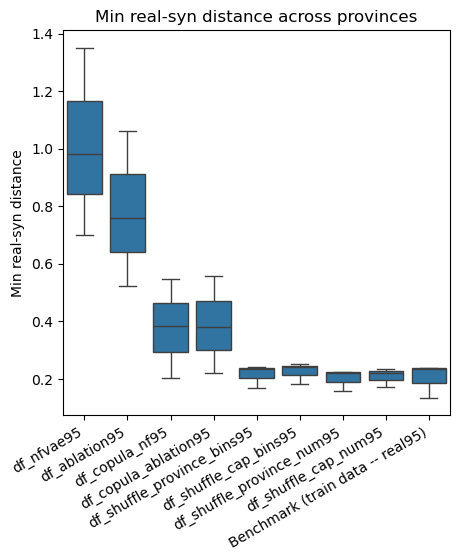

In [4]:
# boxplot function for distances
fig,ax = plt.subplots(1,figsize=(5,5))
sns.boxplot(data=dist.loc[dist.min_distance=='mean'],x='pop_name',y='score',ax=ax)
plt.xticks(rotation=30,ha='right')
ax.set_xlabel("")
ax.set_ylabel("Min real-syn distance")
ax.set_title("Min real-syn distance across provinces")